# Assignment #5: A sentence embedder
Author: Pierre Nugues

## Objectives

In this assignment, you will implement a sentence embedder simplified from Reimers and Gurevych's Sentence-BERT: https://arxiv.org/pdf/1908.10084. S-BERT is written in PyTorch and its code is available from GitHub: https://github.com/UKPLab/sentence-transformers

The objectives of the assignment are to:
* Write a program to embed sentences
* Use neural networks with PyTorch
* Write a short report of 2 to 3 pages to describe your program.

Note: Should your machine be unable to train a model for the whole dataset, then use only a fraction of the dataset such as 10% or less. For this, use the `MINI_CORPUS` constant. See below.

## Overview

We saw we can vectorize words using a dense representation. We can extend this to documents. This enables us to store the resulting vectors in databases and then use fast algorithms for paragraph or document comparisons such as Faiss: https://github.com/facebookresearch/faiss

There are many document vectorization techniques and models are regularly benchmarked, see: https://huggingface.co/spaces/mteb/leaderboard. See also a list of available vector databases here https://db-engines.com/en/ranking/vector+dbms

In this lab, you will program two techniques to vectorize documents into dense vectors. You will first implement a baseline technique and then a toy version of SBERT. SBERT is one of the earliest transformer-based document vectorization algorithm: _Sentence-BERT: Sentence Embeddings using Siamese BERT-Networks_ by Reimers and Gurevych (2019) https://arxiv.org/pdf/1908.10084

## Analysis of the algorithms
Read the Getting Started paragraph of https://github.com/UKPLab/sentence-transformers for an overview.

Read the summary of the SBERT paper as well as Sections 1 and 3, _Introduction_ and _Model_. In the triplet objective function, an anchor is a start sample, the positive sample is close to the anchor, while the negative one is different. Considering a language detector, think of a sentence in Swedish as the anchor. A positive sample would be another sentence in Swedish and a negative one could be a sentence in English.

In the _Method and program struture_ section of your report, you will summarize these sections in 10 to 15 lines. Note that a three-way softmax classifier is simply a logistic regression with three classes.

## Modules

In [1]:
import torch
import torch.nn as nn
import regex as re
from tqdm import tqdm

Use a reduced dataset for the development of your program with `MINI_CORPUS` set to `True`. Once your program is ready, you can train your model on the whole dataset (if you have the time). Set `MINI_CORPUS` to `False` then.

In [2]:
MINI_CORPUS = True  # Set the value to True when you develop the program
MINI_PERCENTAGE = 0.01  # Percentage of the original dataset.
# Depending on your machine, you may even use less than 0.01

## Datasets: SNLI
As dataset, you will use SNLI. SNLI consists of over 500,000 lines with the text of the pairs and their labels. The authors created the dataset by giving volunteers a sentence (the premise) and asking them to write a second sentence (the hypothesis) that is either definitely true
(entailment), that might be true (neutral), or that is definitely false (contradiction).

Read the dataset description from this URL https://nlp.stanford.edu/projects/snli/ and download it.

Please adjust the path to fit your machine

In [3]:
import json
with open('snli_1.0/snli_1.0/snli_1.0_train.jsonl', 'r') as f:
    dataset_list = list(f)

In [4]:
dataset_snli = []
for json_str in dataset_list:
    dataset_snli += [json.loads(json_str)]
    # print(f"result: {result}")
    # print(isinstance(result, dict))

A sample with an agreement in the annotation. The final annotation is the gold label

In [5]:
dataset_snli[300]

{'annotator_labels': ['entailment'],
 'captionID': '3706019259.jpg#3',
 'gold_label': 'entailment',
 'pairID': '3706019259.jpg#3r2e',
 'sentence1': 'A foreign family is walking along a dirt path next to the water.',
 'sentence1_binary_parse': '( ( A ( foreign family ) ) ( ( is ( ( walking ( along ( a ( dirt path ) ) ) ) ( next ( to ( the water ) ) ) ) ) . ) )',
 'sentence1_parse': '(ROOT (S (NP (DT A) (JJ foreign) (NN family)) (VP (VBZ is) (VP (VBG walking) (PP (IN along) (NP (DT a) (NN dirt) (NN path))) (ADVP (JJ next) (PP (TO to) (NP (DT the) (NN water)))))) (. .)))',
 'sentence2': 'A family of foreigners walks by the water.',
 'sentence2_binary_parse': '( ( ( A family ) ( of foreigners ) ) ( ( walks ( by ( the water ) ) ) . ) )',
 'sentence2_parse': '(ROOT (S (NP (NP (DT A) (NN family)) (PP (IN of) (NP (NNS foreigners)))) (VP (VBZ walks) (PP (IN by) (NP (DT the) (NN water)))) (. .)))'}

A sample with no agreement in the annotation. The gold label is `_`

In [6]:
dataset_snli[145]

{'annotator_labels': ['contradiction', 'contradiction', 'neutral', 'neutral'],
 'captionID': '2677109430.jpg#2',
 'gold_label': '-',
 'pairID': '2677109430.jpg#2r1c',
 'sentence1': 'A small group of church-goers watch a choir practice.',
 'sentence1_binary_parse': '( ( ( A ( small group ) ) ( of church-goers ) ) ( ( watch ( a ( choir practice ) ) ) . ) )',
 'sentence1_parse': '(ROOT (S (NP (NP (DT A) (JJ small) (NN group)) (PP (IN of) (NP (NNS church-goers)))) (VP (VBP watch) (NP (DT a) (NN choir) (NN practice))) (. .)))',
 'sentence2': 'A choir performs in front of packed crowd.',
 'sentence2_binary_parse': '( ( A choir ) ( ( performs ( in ( front ( of ( packed crowd ) ) ) ) ) . ) )',
 'sentence2_parse': '(ROOT (S (NP (DT A) (NN choir)) (VP (VBZ performs) (PP (IN in) (NP (NP (NN front)) (PP (IN of) (NP (JJ packed) (NN crowd)))))) (. .)))'}

We remove all the samples that have no agreement

In [7]:
dataset_str = []
for sample in dataset_snli:
    s1 = sample['sentence1']
    s2 = sample['sentence2']
    label = sample['gold_label']
    if label != '-':
        dataset_str += [(s1, s2, label)]

In [8]:
len(dataset_str)

549367

In [9]:
dataset_str[0]

('A person on a horse jumps over a broken down airplane.',
 'A person is training his horse for a competition.',
 'neutral')

In [10]:
dataset_str[1]

('A person on a horse jumps over a broken down airplane.',
 'A person is at a diner, ordering an omelette.',
 'contradiction')

In [11]:
dataset_str[2]

('A person on a horse jumps over a broken down airplane.',
 'A person is outdoors, on a horse.',
 'entailment')

In [12]:
if MINI_CORPUS:
    new_size = int(len(dataset_str) * MINI_PERCENTAGE)
    dataset_str = dataset_str[:new_size]

In [13]:
len(dataset_str)

5493

## Datasets: GloVe

You will first implement a baseline, an easy technique that serves as comparison for more elaborate ones. 

In Sect. 4.1 and Table 1 the authors proposed a baseline technique for computing a semantic
textual similarity between two sentences that uses GloVe embeddings. Describe this technique in 5 to 10 lines in the _Method and program struture_ section. You will create a *Baseline* subsection for this.

### GloVe
You will use a list of pretrained word embeddings to implement the baseline and GloVe is one such vector lists. GloVe is available in different dimensionalities (50, 100, 200, 300) and vocabulary sizes (400,000 words, 1.2M, 2.4M). 

Download the GloVe 6B embeddings from https://nlp.stanford.edu/projects/glove/, uncompress it, and keep the `glove.6B.50d.txt` file of 400,000 words with 50-dimensional vectors.

Please adjust your path to read the file

In [14]:
embedding_file = 'GloVe data/glove.6B.50d.txt'

In [15]:
def read_embeddings(file):
    """
    Return the embeddings in the from of a dictionary
    :param file:
    :return:
    """
    embeddings = {}
    glove = open(file, encoding='utf8')
    for line in glove:
        values = line.strip().split()
        word = values[0]
        vector = torch.tensor(
            list(map(float, values[1:])), dtype=torch.float32)
        embeddings[word] = vector
    glove.close()
    return embeddings

In [16]:
embeddings = read_embeddings(embedding_file)
embedded_words = sorted(list(embeddings.keys()))

In [17]:
embeddings['the']

tensor([ 4.1800e-01,  2.4968e-01, -4.1242e-01,  1.2170e-01,  3.4527e-01,
        -4.4457e-02, -4.9688e-01, -1.7862e-01, -6.6023e-04, -6.5660e-01,
         2.7843e-01, -1.4767e-01, -5.5677e-01,  1.4658e-01, -9.5095e-03,
         1.1658e-02,  1.0204e-01, -1.2792e-01, -8.4430e-01, -1.2181e-01,
        -1.6801e-02, -3.3279e-01, -1.5520e-01, -2.3131e-01, -1.9181e-01,
        -1.8823e+00, -7.6746e-01,  9.9051e-02, -4.2125e-01, -1.9526e-01,
         4.0071e+00, -1.8594e-01, -5.2287e-01, -3.1681e-01,  5.9213e-04,
         7.4449e-03,  1.7778e-01, -1.5897e-01,  1.2041e-02, -5.4223e-02,
        -2.9871e-01, -1.5749e-01, -3.4758e-01, -4.5637e-02, -4.4251e-01,
         1.8785e-01,  2.7849e-03, -1.8411e-01, -1.1514e-01, -7.8581e-01])

In [18]:
d_model = next(iter(embeddings.values())).size()[0]
d_model

50

We read all the words in GloVe

In [19]:
glove_words = []
glove = []
for word, vector in embeddings.items():
    glove_words += [word]
    glove += [vector]

In [20]:
glove_words[:10]

['the', ',', '.', 'of', 'to', 'and', 'in', 'a', '"', "'s"]

And we create a tensor with the vectors

In [21]:
glove = torch.stack(glove)

In [22]:
glove[0, :]

tensor([ 4.1800e-01,  2.4968e-01, -4.1242e-01,  1.2170e-01,  3.4527e-01,
        -4.4457e-02, -4.9688e-01, -1.7862e-01, -6.6023e-04, -6.5660e-01,
         2.7843e-01, -1.4767e-01, -5.5677e-01,  1.4658e-01, -9.5095e-03,
         1.1658e-02,  1.0204e-01, -1.2792e-01, -8.4430e-01, -1.2181e-01,
        -1.6801e-02, -3.3279e-01, -1.5520e-01, -2.3131e-01, -1.9181e-01,
        -1.8823e+00, -7.6746e-01,  9.9051e-02, -4.2125e-01, -1.9526e-01,
         4.0071e+00, -1.8594e-01, -5.2287e-01, -3.1681e-01,  5.9213e-04,
         7.4449e-03,  1.7778e-01, -1.5897e-01,  1.2041e-02, -5.4223e-02,
        -2.9871e-01, -1.5749e-01, -3.4758e-01, -4.5637e-02, -4.4251e-01,
         1.8785e-01,  2.7849e-03, -1.8411e-01, -1.1514e-01, -7.8581e-01])

The number of word embeddings (400,000) and their dimension (50)

In [23]:
glove.size()

torch.Size([400000, 50])

In [24]:
d_model = glove.size()[1]
d_model

50

We reserve three special symbols: padding, unknown, and the first classification token of BERT. See the lecture on transformers for a clarification.

In [25]:
specials = ['[PAD]', '[UNK]', '[CLS]']

In [26]:
glove_words = specials + glove_words
glove_words[:10]

['[PAD]', '[UNK]', '[CLS]', 'the', ',', '.', 'of', 'to', 'and', 'in']

We add the vectors for the special tokens to our tensor

In [27]:
glove = torch.vstack((torch.zeros((3, d_model)), glove))

In [28]:
glove.size()

torch.Size([400003, 50])

In [29]:
glove[0, :]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])

In [30]:
glove[3, :]

tensor([ 4.1800e-01,  2.4968e-01, -4.1242e-01,  1.2170e-01,  3.4527e-01,
        -4.4457e-02, -4.9688e-01, -1.7862e-01, -6.6023e-04, -6.5660e-01,
         2.7843e-01, -1.4767e-01, -5.5677e-01,  1.4658e-01, -9.5095e-03,
         1.1658e-02,  1.0204e-01, -1.2792e-01, -8.4430e-01, -1.2181e-01,
        -1.6801e-02, -3.3279e-01, -1.5520e-01, -2.3131e-01, -1.9181e-01,
        -1.8823e+00, -7.6746e-01,  9.9051e-02, -4.2125e-01, -1.9526e-01,
         4.0071e+00, -1.8594e-01, -5.2287e-01, -3.1681e-01,  5.9213e-04,
         7.4449e-03,  1.7778e-01, -1.5897e-01,  1.2041e-02, -5.4223e-02,
        -2.9871e-01, -1.5749e-01, -3.4758e-01, -4.5637e-02, -4.4251e-01,
         1.8785e-01,  2.7849e-03, -1.8411e-01, -1.1514e-01, -7.8581e-01])

## Preprocessing
### Tokenization
You will now tokenize the sentences

Write a regular expression that tokenizes the words, numbers, and punctuation. Use Unicode classes. Note that a punctuation is a single symbol while the words and numbers are sequences.

In [31]:
# Write your code
pattern = '\p{L}+|\p{N}+|\p{Punct}'

Write a tokenization function that takes a string as input and results a list of tokens. Set the string in lower case by default.

In [32]:
# Write your code
def tokenize(sentence, pattern, lc=True):
    if lc:
        sentence = sentence.lower()
    tokens = re.findall(pattern, sentence)
    return tokens

In [33]:
tokenize(dataset_str[0][0], pattern)

['a',
 'person',
 'on',
 'a',
 'horse',
 'jumps',
 'over',
 'a',
 'broken',
 'down',
 'airplane',
 '.']

Write a code that, for each sample of your dataset, builds a triple consisting of:
1. The first tokenized sentence, 
2. The second one, and 
3. The class

Build a list of all these triples to represent your dataset.

In [34]:
# Write your code
dataset_tokens = []
for s1, s2, label in dataset_str:
    tokens1 = tokenize(s1, pattern)
    tokens2 = tokenize(s2, pattern)
    dataset_tokens += [(tokens1, tokens2, label)]

In [35]:
dataset_tokens[0]

(['a',
  'person',
  'on',
  'a',
  'horse',
  'jumps',
  'over',
  'a',
  'broken',
  'down',
  'airplane',
  '.'],
 ['a',
  'person',
  'is',
  'training',
  'his',
  'horse',
  'for',
  'a',
  'competition',
  '.'],
 'neutral')

In [36]:
len(dataset_tokens)

5493

### Indexing

Build token-to-index `token2idx` and index-to-token `idx2token` dictionaries

In [37]:
# Write your code
token2idx = {word: i for i, word in enumerate(glove_words)}
idx2token = {i: word for i, word in enumerate(glove_words)}

In [38]:
token2idx['the'], token2idx['a']

(3, 10)

In [39]:
idx2token[3], idx2token[10]

('the', 'a')

Collect the set of all the labels (classes) from your dataset

In [40]:
# Write your code
"""
labels_set = set()
for s1, s2, label in dataset_tokens:
    labels_set.add(label)
labels = list(labels_set)
"""

labels = ['entailment', 'contradiction', 'neutral']

In [41]:
labels

['entailment', 'contradiction', 'neutral']

Build label-to-index `label2idx` and index-to-label `idx2label` dictionaries

In [42]:
# Write your code
label2idx = {label: i for i, label in enumerate(labels)}
idx2label = {i: label for i, label in enumerate(labels)}

In [43]:
label2idx

{'entailment': 0, 'contradiction': 1, 'neutral': 2}

In [44]:
idx2label

{0: 'entailment', 1: 'contradiction', 2: 'neutral'}

Write a function to convert:
  * A list of tokens into a list of `LongTensor` indices and 
  * The class to a tensor. 

Your function should be able to handle two types: either a list or a string. The tokens are strored in a list and the class (label) is a string

Note that an unknown token in GloVe should be mapped to the `UNK` symbol of index 1. 

In [45]:
# Write your code
def convert_symbols(symbols, symbol2idx):
    if type(symbols) is str:
        try:
            idx = symbol2idx[symbols]
        except KeyError:
            idx = symbol2idx['[UNK]']
        return torch.tensor(idx, dtype=torch.long)
    else:
        indices = []
        for symbol in symbols:
            try:
                idx = symbol2idx[symbol]
            except KeyError:
                idx = symbol2idx['[UNK]']
            indices.append(idx)
        return torch.tensor(indices, dtype=torch.long)


In [46]:
dataset_tokens[0]

(['a',
  'person',
  'on',
  'a',
  'horse',
  'jumps',
  'over',
  'a',
  'broken',
  'down',
  'airplane',
  '.'],
 ['a',
  'person',
  'is',
  'training',
  'his',
  'horse',
  'for',
  'a',
  'competition',
  '.'],
 'neutral')

We convert a list of tokens into a `LongTensor` 

In [47]:
convert_symbols(dataset_tokens[0][0], token2idx)

tensor([   10,   902,    16,    10,  2870, 11073,    77,    10,  2324,   138,
         7353,     5])

In [48]:
convert_symbols(dataset_tokens[0][1], token2idx)

tensor([  10,  902,   17,  791,   29, 2870,   13,   10,  994,    5])

In [49]:
dataset_tokens[0][2]

'neutral'

We convert a label string into a tensor

In [50]:
convert_symbols(dataset_tokens[0][2], label2idx)

tensor(2)

Unknown tokens have the index 1

In [51]:
tokenize('a person on a horsewww', pattern)

['a', 'person', 'on', 'a', 'horsewww']

In [52]:
convert_symbols(tokenize('a person on a horsewww wxwx', pattern), token2idx)

tensor([ 10, 902,  16,  10,   1,   1])

Replace the tokens and labels in your dataset by their indices.

In [53]:
# Write your code
dataset = []
for s1, s2, label in dataset_tokens:
    x1 = convert_symbols(s1, token2idx)
    x2 = convert_symbols(s2, token2idx)
    y = convert_symbols(label, label2idx)
    dataset += [(x1, x2, y)]

In [54]:
dataset[1]

(tensor([   10,   902,    16,    10,  2870, 11073,    77,    10,  2324,   138,
          7353,     5]),
 tensor([    10,    902,     17,     25,     10,  19304,      4,   7490,     32,
         119031,      5]),
 tensor(1))

### PyTorch `Embedding` class

We now store the GloVe vectors in a PyTorch `Embedding` object

In [55]:
glove_embs = nn.Embedding(glove.size()[0],
glove.size()[1],
padding_idx=0).from_pretrained(glove)

We access the embedding for _the_ with its index

In [56]:
glove_embs(torch.LongTensor([3]))

tensor([[ 4.1800e-01,  2.4968e-01, -4.1242e-01,  1.2170e-01,  3.4527e-01,
         -4.4457e-02, -4.9688e-01, -1.7862e-01, -6.6023e-04, -6.5660e-01,
          2.7843e-01, -1.4767e-01, -5.5677e-01,  1.4658e-01, -9.5095e-03,
          1.1658e-02,  1.0204e-01, -1.2792e-01, -8.4430e-01, -1.2181e-01,
         -1.6801e-02, -3.3279e-01, -1.5520e-01, -2.3131e-01, -1.9181e-01,
         -1.8823e+00, -7.6746e-01,  9.9051e-02, -4.2125e-01, -1.9526e-01,
          4.0071e+00, -1.8594e-01, -5.2287e-01, -3.1681e-01,  5.9213e-04,
          7.4449e-03,  1.7778e-01, -1.5897e-01,  1.2041e-02, -5.4223e-02,
         -2.9871e-01, -1.5749e-01, -3.4758e-01, -4.5637e-02, -4.4251e-01,
          1.8785e-01,  2.7849e-03, -1.8411e-01, -1.1514e-01, -7.8581e-01]])

## Baseline: Mean of GloVe Embeddings

In [57]:
s1_str = dataset_str[0][0]
s2_str = dataset_str[0][1]
s3_str = dataset_str[0][2]
s1_str, s2_str, s3_str

('A person on a horse jumps over a broken down airplane.',
 'A person is training his horse for a competition.',
 'neutral')

In [58]:
s1_idx = dataset[0][0]
s2_idx = dataset[0][1]
s3_idx = dataset[0][2]
s1_idx, s2_idx, s3_idx

(tensor([   10,   902,    16,    10,  2870, 11073,    77,    10,  2324,   138,
          7353,     5]),
 tensor([  10,  902,   17,  791,   29, 2870,   13,   10,  994,    5]),
 tensor(2))

Write a function that takes a list of indices and the GloVe embeddings as input and that computes the mean of the word embeddings

In [59]:
# Write your code here
def mean_embs(input_idx: torch.LongTensor, glove_embs: nn.Embedding) -> torch.tensor:
    embs = glove_embs(input_idx)
    return embs.mean(dim=0)

In [60]:
dataset[0]

(tensor([   10,   902,    16,    10,  2870, 11073,    77,    10,  2324,   138,
          7353,     5]),
 tensor([  10,  902,   17,  791,   29, 2870,   13,   10,  994,    5]),
 tensor(2))

In [61]:
mean_embs(dataset[0][0], glove_embs)

tensor([ 0.1988,  0.1043,  0.0180, -0.0851,  0.5251,  0.4551, -0.4729, -0.0604,
         0.1335, -0.1824, -0.1023, -0.2145, -0.3953,  0.3100,  0.3126, -0.1235,
        -0.1631,  0.1271, -0.8334, -0.5111,  0.0911,  0.1766, -0.1190, -0.1795,
         0.2117, -1.6935, -0.1754,  0.3900,  0.4590, -0.1137,  3.0905, -0.0358,
        -0.2404,  0.2918,  0.1015, -0.0099,  0.2168,  0.1239,  0.1565, -0.2061,
        -0.1449,  0.0871, -0.1085,  0.1992, -0.0306, -0.2125,  0.1155, -0.3489,
         0.2139, -0.1993])

Write a function to compute the cosine of two vectors. You will return `torch.tensor(0.0)` if one of the vectors is zero

In [62]:
# Write your code here
def compute_cosine(v1: torch.tensor, v2: torch.tensor) -> torch.tensor:
    if torch.equal(v1, torch.zeros_like(v1)) or torch.equal(v2, torch.zeros_like(v2)):
        return torch.tensor(0.0)
    return torch.dot(v1, v2) / (torch.norm(v1) * torch.norm(v2))


In [63]:
v1 = mean_embs(s1_idx, glove_embs)
v2 = mean_embs(s2_idx, glove_embs)
v1, v2

(tensor([ 0.1988,  0.1043,  0.0180, -0.0851,  0.5251,  0.4551, -0.4729, -0.0604,
          0.1335, -0.1824, -0.1023, -0.2145, -0.3953,  0.3100,  0.3126, -0.1235,
         -0.1631,  0.1271, -0.8334, -0.5111,  0.0911,  0.1766, -0.1190, -0.1795,
          0.2117, -1.6935, -0.1754,  0.3900,  0.4590, -0.1137,  3.0905, -0.0358,
         -0.2404,  0.2918,  0.1015, -0.0099,  0.2168,  0.1239,  0.1565, -0.2061,
         -0.1449,  0.0871, -0.1085,  0.1992, -0.0306, -0.2125,  0.1155, -0.3489,
          0.2139, -0.1993]),
 tensor([ 1.0878e-01,  3.7231e-01, -4.7114e-01, -1.3591e-02,  5.1340e-01,
          3.7193e-01, -4.4592e-01, -5.9900e-02,  2.5352e-01, -1.3076e-01,
          1.6231e-01,  2.3146e-03, -3.6474e-01,  2.3840e-03,  3.4653e-01,
         -2.1769e-01,  2.5946e-02,  3.9537e-01, -6.9517e-01, -3.4811e-01,
         -4.9454e-02,  1.4977e-01, -1.2447e-01,  8.1851e-02,  6.2581e-02,
         -1.8692e+00, -3.1502e-01, -7.4079e-02,  1.2478e-01, -1.6717e-02,
          3.3707e+00,  8.7725e-02, -4.018

In [64]:
v1.size(), v2.size()

(torch.Size([50]), torch.Size([50]))

In [65]:
compute_cosine(v1, v2)

tensor(0.9426)

We now compute the cosine of pairs for each class

In [66]:
cos_sim = {'entailment': 0.0, 'neutral': 0.0, 'contradiction': 0.0}
cnt = {'entailment': 0.0, 'neutral': 0.0, 'contradiction': 0.0}
for data in tqdm(dataset):
    cos_val = compute_cosine(
        mean_embs(data[0], glove_embs),
        mean_embs(data[1], glove_embs))
    class_name = idx2label[data[2].item()]
    cos_sim[class_name] += cos_val
    cnt[class_name] += 1

100%|██████████| 5493/5493 [00:00<00:00, 8423.01it/s]


You will comment these values in your report

In [67]:
for key in cos_sim.keys():
    cos_sim[key] /= cnt[key]
cos_sim

{'entailment': tensor(0.9453),
 'neutral': tensor(0.9385),
 'contradiction': tensor(0.9298)}

## SBERT: The Stacks

You will now create the SBERT architecture and replicate the pipeline in Fig. 1 in the paper. In the next cells, we walk through the figure from the bottom to the top.

The first layer builds an input consisting of two sentences

In [68]:
p1 = torch.LongTensor(
    list(map(lambda x: token2idx.get(x, 1), tokenize('the small cat', pattern))))
p2 = torch.LongTensor(
    list(map(lambda x: token2idx.get(x, 1), tokenize('the very big dog', pattern))))
p1, p2

(tensor([   3,  360, 5453]), tensor([   3,  194,  368, 2929]))

Then we have the BERT layer. Using PyTorch classes, create an encoder of four layers where each layer has five heads. You will use the classes `TransformerEncoderLayer` and `TransformerEncoder`. The dimensionality `d_model` is 50 as this is the size of GloVe vectors.

In [69]:
# Write your code
encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=5)
transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=4)

/home/oscar/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [70]:
transformer_encoder

TransformerEncoder(
  (layers): ModuleList(
    (0-3): 4 x TransformerEncoderLayer(
      (self_attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=50, out_features=50, bias=True)
      )
      (linear1): Linear(in_features=50, out_features=2048, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (linear2): Linear(in_features=2048, out_features=50, bias=True)
      (norm1): LayerNorm((50,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((50,), eps=1e-05, elementwise_affine=True)
      (dropout1): Dropout(p=0.1, inplace=False)
      (dropout2): Dropout(p=0.1, inplace=False)
    )
  )
)

We have now a BERT encoder. We associate each input index to an embedding. In the next cell, we create three embedding vectors correponding to three words.

In the rest of the program, all our batches will have only one sample to eliminate the need for padding.

In [71]:
src = torch.rand(3, d_model)
src

tensor([[7.9869e-01, 4.0992e-01, 3.9706e-01, 4.0608e-01, 5.2162e-01, 4.7479e-01,
         7.9576e-01, 2.2609e-01, 7.4674e-01, 9.7902e-01, 5.9220e-01, 8.4274e-01,
         6.4434e-02, 9.3559e-01, 4.8945e-01, 4.3761e-01, 3.1667e-01, 4.9250e-01,
         3.8621e-01, 5.4175e-01, 3.3998e-01, 7.6968e-02, 8.6747e-01, 3.1925e-01,
         6.3027e-01, 6.3631e-01, 3.9579e-01, 2.1454e-02, 6.6536e-01, 3.8259e-01,
         1.3069e-01, 1.0481e-01, 3.7356e-01, 7.9920e-01, 2.7030e-01, 2.6574e-01,
         5.9608e-01, 4.2225e-01, 3.8137e-01, 3.0961e-01, 9.1479e-01, 1.2154e-01,
         8.1085e-01, 2.0580e-01, 8.6229e-01, 6.9402e-01, 1.2196e-01, 1.4650e-01,
         6.5053e-01, 1.1256e-01],
        [6.0683e-01, 1.7352e-01, 9.9250e-01, 4.5312e-01, 9.9307e-01, 7.3762e-01,
         8.1816e-03, 1.5181e-01, 4.0526e-01, 1.0233e-01, 5.0846e-01, 7.0422e-01,
         5.0080e-01, 3.1942e-01, 4.0842e-01, 4.9172e-01, 3.3720e-01, 7.1800e-01,
         4.0909e-01, 2.7407e-02, 5.8310e-02, 9.9954e-01, 7.4428e-01, 5.2807

We pass it to the encoder to encode the input into three vectors of the same size

In [72]:
out = transformer_encoder(src)
out

tensor([[-1.5273,  0.9600, -0.6093, -0.6646, -0.6597,  1.1945,  1.1089,  1.3499,
          0.7104,  0.4301,  0.1325, -0.1241, -1.3403, -0.4634,  0.5402, -1.5561,
         -1.1423, -1.1000,  1.1864, -0.0523,  0.0566, -1.8818,  0.5103, -1.0161,
          0.0258,  1.9655, -0.1804,  0.6953,  0.8691,  0.5261,  0.4222, -0.2714,
          2.0409, -0.4910, -1.7309, -0.4172,  0.0943, -0.6705, -1.8872, -0.9480,
          1.6792, -0.0728,  0.3494,  0.2762,  1.2975,  0.4296, -1.6215,  0.3692,
          0.2407,  0.9673],
        [-0.6800, -1.5413,  1.1617,  0.1298,  0.8917,  0.5596, -0.2446,  1.0260,
          1.0975, -0.1537,  0.1419, -0.6344, -0.5571, -2.0732, -0.6357, -2.5549,
         -0.2038, -0.4180,  0.5532, -1.2640, -0.7922,  0.1034,  1.1163, -1.3783,
          0.3447,  1.5014,  0.2621,  1.3420, -0.9427,  2.0574,  2.2395, -0.1421,
          0.4107, -1.0464,  0.1306, -1.0431, -0.4672,  1.3655, -0.4376, -1.2799,
         -0.3030, -0.0617, -0.2782,  0.4590,  1.1700,  0.3086, -0.6566, -0.2776,


Write a statement that will compute the mean of these embeddings. You will use the `mean(dim)` method

In [73]:
# Write your code
out_mean = out.mean(dim=0)
out_mean

tensor([-1.2396, -0.3976, -0.0464,  0.0381, -0.6207,  0.5626,  0.1091,  0.9716,
         0.4134, -0.1065, -0.3453, -0.4919, -0.4044, -1.1870,  0.3929, -1.7085,
        -0.9380, -1.1844,  0.9554, -0.2827, -0.5476, -0.5976,  0.7240, -1.0098,
         0.0764,  1.6623,  0.1973,  1.4918,  0.2528,  1.3250,  1.2322, -0.1574,
         1.0970, -1.0720, -0.6820, -0.6751, -0.1580,  0.2034, -0.2702, -0.9892,
         0.8789,  0.1505,  0.1769,  0.0929,  0.8557,  0.1413, -0.7363,  0.5012,
         0.3535,  0.9924], grad_fn=<MeanBackward1>)

Once we have understood the first steps of SBERT, we can implement them in a class.

In the next cell, write the `forward()` method that takes the two sentences as input in the form of two `LongTensor` of indices.
1. Extract their embeddings from the GloVe embedding matrix.
2. Encode them with the transformer, and 
3. Compute their respective mean. You will call these vectors $\mathbf{u}$ and $\mathbf{v}$
4. Return these two vectors of means. 

In [74]:
# Write the forward method
class SBERT(nn.Module):
    def __init__(self, nbr_classes, glove, d_model=50, nhead=5, num_layers=4):
        super().__init__()
        self.d_model = d_model
        self.embeddings = nn.Embedding(
            glove.size()[0],
            glove.size()[1],
            padding_idx=0).from_pretrained(glove)
        self.encoder_layer = nn.TransformerEncoderLayer(d_model, nhead)
        self.transformer_encoder = nn.TransformerEncoder(
            self.encoder_layer, num_layers=num_layers)
        # We do not use this last line for now
        self.fc = nn.Linear(3 * d_model, nbr_classes)

    def forward(self, u, v):
        u = self.embeddings(u)
        v = self.embeddings(v)
        u = self.transformer_encoder(u)
        v = self.transformer_encoder(v)
        u = u.mean(dim=0)
        v = v.mean(dim=0)
        return u, v

In [75]:
sbert = SBERT(3, glove)

In [76]:
sbert.eval()

SBERT(
  (embeddings): Embedding(400003, 50)
  (encoder_layer): TransformerEncoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=50, out_features=50, bias=True)
    )
    (linear1): Linear(in_features=50, out_features=2048, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (linear2): Linear(in_features=2048, out_features=50, bias=True)
    (norm1): LayerNorm((50,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((50,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.1, inplace=False)
    (dropout2): Dropout(p=0.1, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-3): 4 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=50, out_features=50, bias=True)
        )
        (linear1): Linear(in_features=50, out_features=2048, bias=True)
        (dropout): Dropout(p=0.

In [77]:
dataset[0]

(tensor([   10,   902,    16,    10,  2870, 11073,    77,    10,  2324,   138,
          7353,     5]),
 tensor([  10,  902,   17,  791,   29, 2870,   13,   10,  994,    5]),
 tensor(2))

In [78]:
u, v = sbert(dataset[0][0], dataset[0][1])

In [79]:
u, v

(tensor([ 6.8417e-03,  1.2471e+00, -6.0113e-01,  6.4204e-01,  1.4145e-01,
         -1.6292e-01, -1.1143e+00, -3.0791e-02,  1.2481e+00, -1.2497e+00,
          5.9703e-01,  1.3712e-02, -1.8901e+00,  1.2502e+00,  5.2542e-01,
          6.1148e-01,  2.0110e+00,  5.3191e-04,  7.4153e-02, -1.7274e-01,
          8.0745e-01,  1.0392e+00, -1.4829e+00, -1.4686e+00, -6.3498e-01,
         -2.1219e+00,  2.6609e-01, -2.9389e-01, -1.0923e+00, -2.9799e-01,
          1.5527e+00, -1.0035e+00,  8.7872e-01, -3.7961e-01,  1.2611e+00,
         -2.4842e-01,  1.1421e+00, -2.3525e-01, -1.0649e+00, -1.3096e+00,
          1.4559e-01, -8.3565e-01,  8.8376e-01, -3.7018e-01,  5.9967e-01,
         -2.4761e-01,  1.1052e+00,  2.7283e-02,  9.4663e-01, -7.1568e-01],
        grad_fn=<MeanBackward1>),
 tensor([ 0.0524,  1.4210, -0.8081,  0.2262,  0.1673,  0.0494, -1.3689, -0.4148,
          1.0811, -1.1450,  0.9079,  0.2128, -1.8392,  0.8040,  0.2362,  0.5926,
          2.2157, -0.1631,  0.2221, -0.5283,  0.6507,  0.8830, 

Write the code that concatenate `u`, `v`, and `|u-v|`

In [80]:
# Write your code
diff = u - v
diff = abs(diff)
concat_tensor = torch.cat((u, v, diff), dim=0)
concat_tensor

tensor([ 6.8417e-03,  1.2471e+00, -6.0113e-01,  6.4204e-01,  1.4145e-01,
        -1.6292e-01, -1.1143e+00, -3.0791e-02,  1.2481e+00, -1.2497e+00,
         5.9703e-01,  1.3712e-02, -1.8901e+00,  1.2502e+00,  5.2542e-01,
         6.1148e-01,  2.0110e+00,  5.3191e-04,  7.4153e-02, -1.7274e-01,
         8.0745e-01,  1.0392e+00, -1.4829e+00, -1.4686e+00, -6.3498e-01,
        -2.1219e+00,  2.6609e-01, -2.9389e-01, -1.0923e+00, -2.9799e-01,
         1.5527e+00, -1.0035e+00,  8.7872e-01, -3.7961e-01,  1.2611e+00,
        -2.4842e-01,  1.1421e+00, -2.3525e-01, -1.0649e+00, -1.3096e+00,
         1.4559e-01, -8.3565e-01,  8.8376e-01, -3.7018e-01,  5.9967e-01,
        -2.4761e-01,  1.1052e+00,  2.7283e-02,  9.4663e-01, -7.1568e-01,
         5.2396e-02,  1.4210e+00, -8.0805e-01,  2.2615e-01,  1.6734e-01,
         4.9434e-02, -1.3689e+00, -4.1477e-01,  1.0811e+00, -1.1450e+00,
         9.0785e-01,  2.1278e-01, -1.8392e+00,  8.0397e-01,  2.3623e-01,
         5.9258e-01,  2.2157e+00, -1.6314e-01,  2.2

## Logistic regression head

We are now ready to add the logistic regression head. Complement the `forward()` method so that it concatenates, $\mathbf{u}$, $\mathbf{v}$, and $\mathbf{|u - v|}$ and outputs three classes. You have only two lines to add.

In [81]:
# Write the forward() method
class SBERT(nn.Module):
    def __init__(self, nbr_classes, glove, d_model=50, nhead=5, num_layers=4):
        super().__init__()
        self.d_model = d_model
        self.embeddings = nn.Embedding(glove.size()[0],
                                       glove.size()[1],
                                       padding_idx=0).from_pretrained(glove)
        self.encoder_layer = nn.TransformerEncoderLayer(d_model, nhead)
        self.transformer_encoder = nn.TransformerEncoder(
            self.encoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(3 * d_model, nbr_classes)

    def forward(self, u, v):
        u = self.embeddings(u)
        v = self.embeddings(v)
        u = self.transformer_encoder(u)
        v = self.transformer_encoder(v)
        u = u.mean(dim=0)
        v = v.mean(dim=0)
        diff = abs(u - v)
        x = torch.cat((u, v, diff), dim=0)
        return self.fc(x)

In [82]:
sbert = SBERT(3, glove)

In [83]:
sbert.eval()

SBERT(
  (embeddings): Embedding(400003, 50)
  (encoder_layer): TransformerEncoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=50, out_features=50, bias=True)
    )
    (linear1): Linear(in_features=50, out_features=2048, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (linear2): Linear(in_features=2048, out_features=50, bias=True)
    (norm1): LayerNorm((50,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((50,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.1, inplace=False)
    (dropout2): Dropout(p=0.1, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-3): 4 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=50, out_features=50, bias=True)
        )
        (linear1): Linear(in_features=50, out_features=2048, bias=True)
        (dropout): Dropout(p=0.

In [84]:
dataset[0]

(tensor([   10,   902,    16,    10,  2870, 11073,    77,    10,  2324,   138,
          7353,     5]),
 tensor([  10,  902,   17,  791,   29, 2870,   13,   10,  994,    5]),
 tensor(2))

We apply the complete model and we have three outputs

In [85]:
sbert(dataset[0][0], dataset[0][1])

tensor([ 0.5493,  0.1353, -0.2695], grad_fn=<ViewBackward0>)

## Training SBERT
We now train the model

In [86]:
sbert.train()

SBERT(
  (embeddings): Embedding(400003, 50)
  (encoder_layer): TransformerEncoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=50, out_features=50, bias=True)
    )
    (linear1): Linear(in_features=50, out_features=2048, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (linear2): Linear(in_features=2048, out_features=50, bias=True)
    (norm1): LayerNorm((50,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((50,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.1, inplace=False)
    (dropout2): Dropout(p=0.1, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-3): 4 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=50, out_features=50, bias=True)
        )
        (linear1): Linear(in_features=50, out_features=2048, bias=True)
        (dropout): Dropout(p=0.

In [87]:
loss_fn = nn.CrossEntropyLoss()    # cross entropy loss
optimizer = torch.optim.Adam(sbert.parameters(), lr=0.00002)

In [88]:
dataset[0]

(tensor([   10,   902,    16,    10,  2870, 11073,    77,    10,  2324,   138,
          7353,     5]),
 tensor([  10,  902,   17,  791,   29, 2870,   13,   10,  994,    5]),
 tensor(2))

Write the training loop. You will process one sample at a time to simplify it i.e. no batch. Record the training loss.

A better design would use a `Dataset` object. We will see this construct in the last laboratory.

In [89]:
# Write your code
ce_train_loss = []
for epoch in range(5):
    loss_train = 0
    for data in tqdm(dataset, ncols=80):
        optimizer.zero_grad()
        y_pred = sbert(data[0], data[1])
        loss = loss_fn(y_pred.view(1, -1), data[2].view(1))
        loss.backward()
        optimizer.step()
        loss_train += loss.item()
    ce_train_loss.append(loss_train / len(dataset))

100%|███████████████████████████████████████| 5493/5493 [01:46<00:00, 51.42it/s]


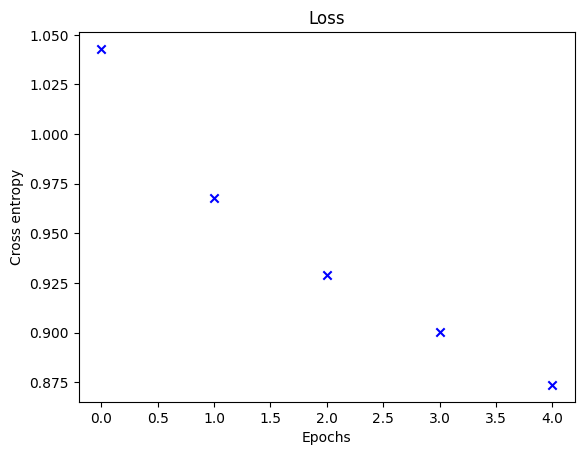

In [90]:
import matplotlib.pyplot as plt

plt.scatter(range(len(ce_train_loss)),
            ce_train_loss, c='b', marker='x')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Cross entropy')
plt.show()

In [91]:
torch.save(sbert, 'sbert_mini.pt')

In [92]:
sbert_saved = torch.load('sbert_mini.pt', weights_only=False)

In [93]:
dataset[0][1]

tensor([  10,  902,   17,  791,   29, 2870,   13,   10,  994,    5])

In [95]:
sbert(dataset[0][0], dataset[0][1])

tensor([-0.9504, -0.4566,  1.6806], grad_fn=<ViewBackward0>)

We write a function to apply the model to a sentence. 

In [96]:
def encode_sbert(model, token_indices):
    model.eval()
    with torch.no_grad():
        v = model.embeddings(token_indices)
        v = model.transformer_encoder(v).mean(dim=0)
        return v

In [97]:
encode_sbert(sbert, dataset[0][1])

tensor([ 5.5014e-01,  2.2175e+00,  1.0943e-02, -1.5194e+00,  2.1388e-01,
         1.6797e+00,  1.1322e+00,  5.0665e-01, -3.5126e-01,  2.0733e+00,
        -6.5628e-01, -4.8998e-01,  1.0700e-01, -2.9056e-01,  6.3894e-01,
        -2.0036e-01, -8.7259e-01, -4.8582e-02,  5.5429e-01,  7.8383e-01,
        -7.3428e-01, -1.4809e+00, -1.1853e+00, -8.5416e-01,  5.3131e-01,
         4.9299e-01, -1.7176e-01,  1.6508e-01, -1.5976e+00, -2.3696e-01,
         6.2138e-01, -1.1657e-04,  5.9505e-01, -9.5836e-02, -1.0099e+00,
         3.3183e-01, -1.2716e-01,  1.3237e+00,  6.1533e-01, -1.0503e-01,
        -1.9033e-01,  1.2508e-01, -2.2741e-01, -6.9092e-01,  3.6271e-01,
        -5.1588e-01, -6.7532e-01, -1.0130e+00, -9.1094e-01,  6.1061e-01])

In [98]:
idx2label

{0: 'entailment', 1: 'contradiction', 2: 'neutral'}

We apply the model to all our pairs and, for each pair, we compute the cosine of the resulting embeddings

In [99]:
cos_sim = {'entailment': 0.0, 'neutral': 0.0, 'contradiction': 0.0}
cnt = {'entailment': 0.0, 'neutral': 0.0, 'contradiction': 0.0}
sbert.eval()

for data in tqdm(dataset, ncols=80):
    cos_val = compute_cosine(
        encode_sbert(sbert, data[0]),
        encode_sbert(sbert, data[1]))
    cos_sim[idx2label[data[2].item()]] += cos_val
    cnt[idx2label[data[2].item()]] += 1

100%|██████████████████████████████████████| 5493/5493 [00:19<00:00, 280.58it/s]


In [100]:
cos_sim, cnt

({'entailment': tensor(1250.7367),
  'neutral': tensor(940.1052),
  'contradiction': tensor(755.0894)},
 {'entailment': 1839.0, 'neutral': 1821.0, 'contradiction': 1833.0})

In [101]:
for key in cos_sim.keys():
    cos_sim[key] /= cnt[key]
cos_sim

{'entailment': tensor(0.6801),
 'neutral': tensor(0.5163),
 'contradiction': tensor(0.4119)}

## Applying the Embedder to Sentences

In [102]:
sentences = [
    "The weather is lovely today.",
    "It's so sunny outside!",
    "He drove to the stadium.",
]

In [103]:
tokenized_sents = [tokenize(sent, pattern) for sent in sentences]
tokenized_sents

[['the', 'weather', 'is', 'lovely', 'today', '.'],
 ['it', "'", 's', 'so', 'sunny', 'outside', '!'],
 ['he', 'drove', 'to', 'the', 'stadium', '.']]

In [104]:
indexed_sents = [convert_symbols(sent, token2idx) for sent in tokenized_sents]
indexed_sents

[tensor([    3,  1623,    17, 11130,   376,     5]),
 tensor([  23,   60, 1537,  103, 9328,  590,  808]),
 tensor([  21, 3189,    7,    3, 1355,    5])]

In [105]:
encoded_sents = [encode_sbert(sbert, sent) for sent in indexed_sents]
encoded_sents

[tensor([-1.8848e-01,  1.1982e+00,  2.5010e-02,  3.9504e-01, -1.0252e+00,
         -1.5856e-01,  5.4349e-01, -3.9641e-01,  1.5055e+00,  1.6015e-01,
         -6.6313e-02,  7.4331e-01, -2.3850e-01, -7.7391e-01,  3.5829e-01,
          5.6133e-01,  1.1988e+00, -4.9377e-01, -5.9495e-01,  1.9928e-03,
          1.0307e+00,  1.9247e+00, -1.1480e+00, -1.9186e+00, -3.0253e-01,
          3.2228e-01, -9.7055e-01,  1.5588e-01, -9.2422e-01,  8.3377e-01,
          1.1448e+00, -9.1864e-02,  2.1595e+00,  2.7171e-01,  6.3378e-01,
         -4.5301e-01, -7.9965e-01, -3.1435e-01, -3.2487e-01,  3.0877e-01,
         -3.9673e-01,  3.3833e-02,  4.5688e-01, -3.3914e-01,  2.7871e-01,
         -1.7331e+00, -5.1257e-01, -1.7199e+00, -1.0865e+00,  7.6033e-01]),
 tensor([-5.0900e-01,  2.4083e-01,  7.9409e-02,  8.9291e-01, -4.0303e-01,
         -7.8569e-01, -1.1791e-01, -7.7999e-01,  1.6054e+00, -6.1590e-01,
         -8.8663e-01,  5.6273e-01,  1.3995e-01, -2.1909e-01,  4.2992e-01,
          4.9234e-01,  1.0839e+00, -

In [107]:
torch.tensor([compute_cosine(s1, s2)
for s1 in encoded_sents
for s2 in encoded_sents]).reshape(len(sentences), len(sentences))

tensor([[1.0000, 0.8269, 0.1600],
        [0.8269, 1.0000, 0.0307],
        [0.1600, 0.0307, 1.0000]])

## Turning in your assignment

Now your are done with the program. To complete this assignment, you will write a report where you will:
1. Write a short individual report on your program. I recommend that you use this structure for your report:
      1. Objectives and dataset
      2. Method and program structure, where you should outline your program and possibly describe difficult parts.
      3. Results.
      4. Conclusion.
2. In Sect. _Method and program structure_, do not forget to:
   * Summarize the baseline
   * Summarize SBERT

The whole report should be of 2 to 3 pages.

Submit your report as well as your **notebook** (for archiving purposes) to Canvas: https://canvas.education.lu.se/. To write your report, use Latex. This will probably help you structure your text. You can use the Overleaf online editor (www.overleaf.com). You will then upload a PDF file in Canvas.

The submission deadline is October 18, 2024.